# Successful Sexual Activity Project

The goal of this project is to determine the frequency of sexual activity over the course of the year. Recently, we have noticed a lot of our peer's birthdays have fallen in the late summer, suggesting that there is (as expected) increased sexual activity in the winter. However, we have also noticed that a lot of birthdays also land in mid-to-late November, suggesting that there may be a "Valentine's Day boost" in sexual activity.

Using data on pregnancy length, birthday frequencies and conception success rate based on ovulation cycle, as well as Bayesian statistics, we seek to model as rigorously as possible sexual activity distribution over time, which hopefully supports / refutes some of our hypotheses above.

## Methodology

In [49]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import dirichlet
from datetime import timedelta

Description of the datasets and the probabilities we need to calculate are detailed in the PDf writeup. Here,  I will describe the distribution that we will utilize for those probabilities.

Our approach to calculate the probabilities take on Bayesian principles. In other words, we will not be using solely the datasets we have found to calculate our probabilities. Rather, we have a hypothesis / prior knowledge (i.e. prior) on these probabilities and use information from the datasets to update our knowledge, thereby creating updated probabilities (i.e. posterior). We decide to do so, since our datsets are relatively small and are likely to carry noise.

For our priors, we decide to use the Dirichlet distribution, as it is a multivariate generalization of the Beta distribution. In short, the Dirichlet distribution of dimension k have k parameters that describe the distribution over k groups. The size of the parameters relative to each other describe the frequency that a random variable will fall into each group, and the magnitude of the parameters acts as a smoothing parameter. Similar to the Beta distribution, the larger the parameters are, the smoother the distributions are. Below are a few examples that illustrate that.

In [50]:
size = 1000
smaller_param = dirichlet.rvs([1]*10, size = size)
larger_param = dirichlet.rvs([100]*10, size = size)

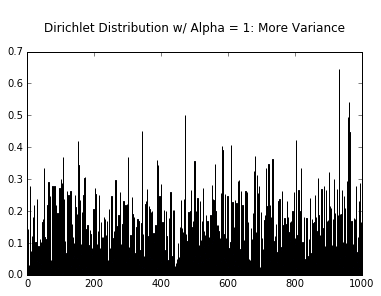

In [51]:
plt.bar(range(size),[x[0] for x in smaller_param])
plt.title('\nDirichlet Distribution w/ Alpha = 1: More Variance\n')

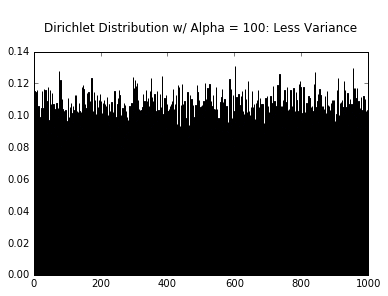

In [52]:
plt.bar(range(size),[x[0] for x in larger_param])
plt.title('\nDirichlet Distribution w/ Alpha = 100: Less Variance\n')

Another key reason why we use the Dirichlet distribution as a prior is that it is the conjugate prior of the multinomial distribution, which is what all of our datasets essentially are comparised of. This allows us to calulate the posterior (updated) probability distributions easily, as it is simply also a Dirichlet distributions with updated parameters.

By visually observing the variance of the Dirichlet Distribution, we decided that setting the priors with alpha at around 5 was a good proxy for our analysis.

## Birthday Data

Here, we assume a conservative prior that the frequency of birthday across all days are uniform. Updating it with real data shows that this is not actually the case.

In [53]:
birthday_data = pd.read_csv("bdata.txt", delimiter=r"\s+")[:-1]
birthday_data['date_edited'] = birthday_data.date.map(lambda x: dt.date(year = 2000, month=int(x[0:2]), day=int(x[2:4])))
birthday_data = birthday_data[birthday_data['date'] != '0229']
birthday_data['doy'] = range(0,365)

In [54]:
dirichlet_bdays = np.array([1.]*365)
for i,row in birthday_data.iterrows():
    dirichlet_bdays[row['doy']] = dirichlet_bdays[row['doy']] + row['count']
dirichlet_bdays = dirichlet_bdays / sum(dirichlet_bdays) * 5 * len(dirichlet_bdays)

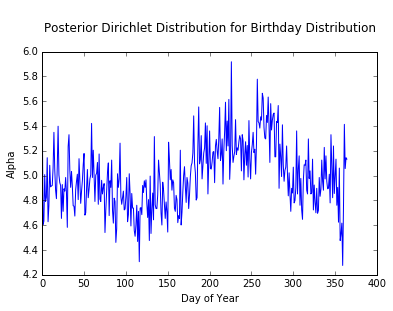

In [55]:
plt.plot(dirichlet_bdays)
plt.title('\nPosterior Dirichlet Distribution for Birthday Distribution\n')
plt.xlabel('Day of Year')
plt.ylabel('Alpha')

## Pregnancy Length Data

Here, we assume a (very) conservative prior that pregnancy lengths across 32 to 45 weeks is uniform. Updating it with real data shows that this is not actually the case.

In [56]:
# Dirichlet Distribution for Pregnancy Length
plength_data = pd.read_csv('pregnancy_length.csv')
plength_data.head()

,Day,Week,Births,Running Total,Percent,Running Total %
0,245,"35W,0D",14,14,0.10%,0.10%
1,246,"35W,1D",18,32,0.20%,0.30%
2,247,"35W,2D",12,44,0.10%,0.40%
3,248,"35W,3D",22,66,0.20%,0.60%
4,249,"35W,4D",19,85,0.20%,0.70%


In [57]:
dirichlet_plength = np.array([1.]*(13*7))
for i,row in plength_data.iterrows():
    day_length = row['Day']-(32*7)
    dirichlet_plength[day_length] = dirichlet_plength[day_length] + row['Births']
dirichlet_plength = dirichlet_plength / sum(dirichlet_plength) * 5 * len(dirichlet_plength)

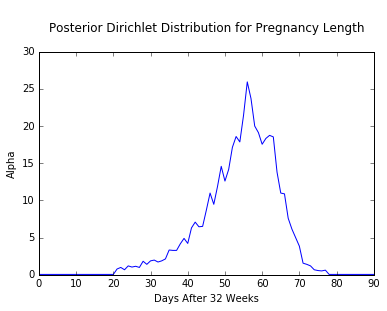

In [58]:
plt.plot(dirichlet_plength)
plt.title('\nPosterior Dirichlet Distribution for Pregnancy Length\n')
plt.xlabel('Days After 32 Weeks')
plt.ylabel('Alpha')

## Sexual Activity to Conception Data

Here, we assume a conservative prior that sexual activity to conception time across 0 to 6 days is uniform. Updating it with real data shows that this is not actually the case.

In [59]:
# Dirichlet Distribution for Conception
clength_data = pd.read_csv("conception_experiment.csv")

In [60]:
dirichlet_clength = np.array([1.]*6)
for i, row in clength_data.iterrows():
    days = row['Days to Ovulation'] * -1
    dirichlet_clength[days] = row['Success']
dirichlet_clength = dirichlet_clength/ sum(dirichlet_clength) * 5 * len(dirichlet_clength)

/Users/haroldmli/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


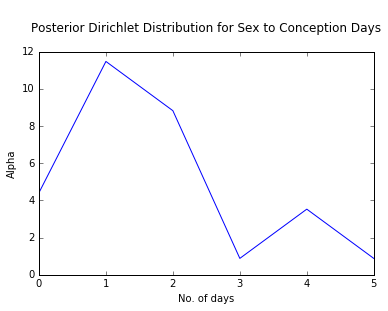

In [61]:
plt.plot(dirichlet_clength)
plt.title('\nPosterior Dirichlet Distribution for Sex to Conception Days\n')
plt.xlabel('No. of days')
plt.ylabel('Alpha')

## Calculating the Sexual Activity Distribution

After defining all of these distributions as Dirichlet distribution, we simulate the sexual activity distribution by simulating the three Dirichlet distributions and multiplying them together. (There is no closed form for the multiplication of multiple Dirichlet distributions so simulation is our best bet here.)

In [62]:
def simulate_date(sex_date, dirichlet_clength, dirichlet_plength, dirichlet_bdays, birthday_data, 
                  c_data, p_data, b_data, n):
    final_sum = np.zeros(n)
    for c in range(len(dirichlet_clength)):
        for p in range(len(dirichlet_plength)):
            # Note: we add two weeks to the pregnancy length here b/c pregnancy length is calculated starting
            # at the time when the woman misses their subsequent period, which is typically 14 days after ovulation.
            birthday = sex_date + timedelta(c) + timedelta(p + 34*7)
            birthday = dt.date(year = 2000, month = birthday.month, day = birthday.day)
            birthday_index = birthday_data[birthday_data.date_edited == birthday]['doy']
            final_sum = final_sum +  c_data[:,c] * p_data[:,p] * b_data[:,birthday_index]
    return(final_sum)

In [63]:
n = 10000
all_days = birthday_data.date_edited.unique()
birthday_sum = []
c_data = dirichlet.rvs(dirichlet_clength, n)
p_data = dirichlet.rvs(dirichlet_plength, n)
b_data = dirichlet.rvs(dirichlet_bdays, n)
for day in all_days:
    birthday_sum.append(simulate_date(day, dirichlet_clength, dirichlet_plength, dirichlet_bdays, birthday_data, 
                                          c_data, p_data, b_data, n))

birthday_sum = pd.DataFrame(birthday_sum, index = all_days, columns = range(n))

/Users/haroldmli/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [64]:
temp = pd.DataFrame(birthday_sum.mean(axis='columns'))
temp.columns = ['mean']
temp['1std'] = birthday_sum.quantile(0.84, axis = 'columns')
temp['-1std'] = birthday_sum.quantile(0.16, axis = 'columns')
temp['2std'] = birthday_sum.quantile(0.97, axis = 'columns')
temp['-2std'] = birthday_sum.quantile(0.03, axis = 'columns')
temp['month'] = temp.index.map(lambda x: x.month)

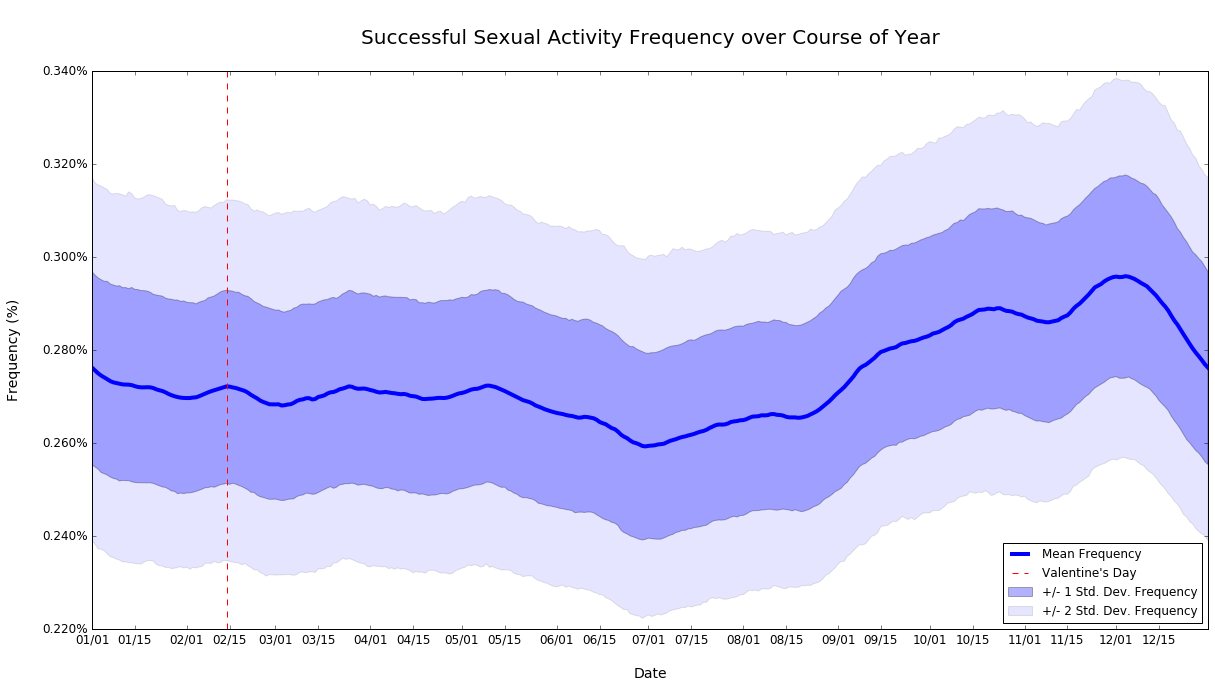

In [70]:
import matplotlib.ticker as mtick
import matplotlib.dates as mdates                                                      

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
ax.plot(temp['mean']*100, linewidth = 4, label = 'Mean Frequency')
ax.fill_between(temp.index, temp['-1std']*100, temp['1std']*100, facecolor='blue', alpha = 0.3,
                label = '+/- 1 Std. Dev. Frequency')
ax.fill_between(temp.index, temp['-2std']*100, temp['2std']*100, facecolor='blue', alpha = 0.1,
                label = '+/- 2 Std. Dev. Frequency')
ax.axvline(pd.to_datetime('2000-02-14'), linewidth=1, color='r', linestyle='--', 
           label = 'Valentine\'s Day')


fmt = '%.3f%%' # Format you want the ticks, e.g. '40%'
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
myFmt = mdates.DateFormatter('%m/%d')
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
ax.xaxis.set_major_formatter(myFmt)
ax.set_ylabel('Frequency (%)\n', fontsize = 14)
ax.set_xlabel('\nDate', fontsize = 14)
ax.set_title('\nSuccessful Sexual Activity Frequency over Course of Year\n', fontsize = 20)
original_major_ticks = ax.xaxis.get_major_ticks()
major_ticks = mdates.DayLocator(bymonthday = [1,15])
ax.xaxis.set_major_locator(major_ticks)

legend = ax.legend(loc='lower right')


As you can see, the winter sexual acitivity holds strong. But also notice the slight "bump" in sexual activity near Valentine's Day (2/14). Perhaps the Valentine's Day hypothesis may be true after all. :)